> **Copyright &copy; 2020 CertifAI Sdn. Bhd.**<br>
 **Copyright &copy; 2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program and the accompanying materials are made available under the
terms of the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). \
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
License for the specific language governing permissions and limitations
under the License. <br>
<br>**SPDX-License-Identifier: Apache-2.0**

# Univariate LSTM, Multi-Step Forecast

## Introduction
This tutorial is to demonstrate the process in build LSTM for the Univariate Time Series Data for Multi Step,The flow of building the LSTM model is same in Univariate Single Step , the only different is in the **Data Sequencing** part.<br> 

It consists of 2 major part which are :<br> 

Part 1 - The Demostration of Building LSTM using Synthetic data<br>
Part 2 - Exercise of building LSTM using shampoo sales data.<br> 


## What will we accomplish?
First, we will show the step in building the LSTM :<br> 

Step 1. Data Preparation (Data Splitting,Data Sequencing,Data Normalization and Batching the Data) <br> 
Step 2. Model Configuration (Vanila LSTM , Stacked LSTM , Bidirectional LSTM) <br> 
Step 3. Train the model <br> 
Step 4. Validate the model using graph  <br> 
Step 5. Evaluation Metrics such as MSE <br> 
Step 6. Plot the forecast result

First , let's us import the package needed

In [1]:
%%capture
# pip install this package to view the summary of LSTM due to original torchsummary does have the function to view the LSTM
# used jupyter install due to it does not have conda version
# %%capture supress information of torchsummaryX installation
!pip install torchsummaryX

In [2]:
#import packages needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import math
from torchsummaryX import summary

# To auto load the customise module
%load_ext autoreload
%autoreload 2
import LSTM_module
import data_module

# Part 1 : Demostration of Building LSTM using Synthetic data

## Hyperparameter
Define the hyper parameter that need to tune the model

In [3]:
split_ratio = 0.70
num_epochs = 60
window_size = 2
batch_size = 2
n_step = 2


# Step 1 : Data Preparation
We create synthetic data to make sure the model is created correctly and having the ability to perform the forecasting <br>

1. First , we will create a sequence of data with `np.array`
2. Then , we will assign a date to the sequence of data with `pd.date_range` and store it to series data by using `pd.Series

In [4]:
#Synthetic Data
univariate_series = np.array([x for x in range(0, 400, 10)])
print(univariate_series.shape)
univariate_series

(40,)


array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
       260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
       390])

In [5]:
univariate_series =pd.Series(univariate_series,pd.date_range("1/1/2020",
                                                             periods=len(univariate_series),
                                                            freq='D'))
univariate_series.head()

2020-01-01     0
2020-01-02    10
2020-01-03    20
2020-01-04    30
2020-01-05    40
Freq: D, dtype: int32

## Data Visualization
Data visualization is import for us to visualize the pattern of data such as trend and seasonality.As the graph below, it is shown that it is an increasing trend in data

Text(0.5, 1.0, 'Synthetic Data')

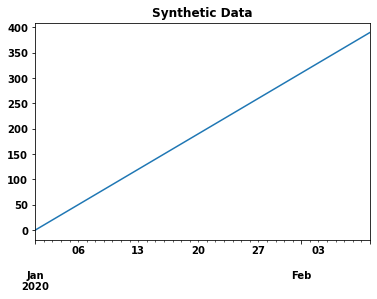

In [6]:
### BEGIN SOLUTION

univariate_series.plot()
plt.title("Synthetic Data")

### BEGIN SOLUTION

## Data Splitting
In Deep Learning, we will split the data into training and test dataset.The training data is used to train the model where the test data is used to validate the performance of the model

In [7]:
split_data = round(len(univariate_series)*split_ratio)
split_data

28

In [8]:
#split data by indexing 
train_data = univariate_series[:split_data]
test_data = univariate_series[split_data:]

train_time = univariate_series.index[:split_data]
test_time = univariate_series.index[split_data:]
print("train_data_shape")
print(train_data.shape)
print("test_data_shape")
print(test_data.shape)

train_data_shape
(28,)
test_data_shape
(12,)


## Data Standardize
Standardize the data to have a 0 mean and unit variance to make our model converge faster

In [9]:
# Build the standard scaler, Use to fit the train data and take the statistic of train data apply in test data
scaler = StandardScaler().fit(train_data.values.reshape(-1, 1))
train_data_standard = scaler.transform(train_data.values.reshape(-1, 1))
test_data_standard = scaler.transform(test_data.values.reshape(-1, 1))

## Data Sequencing
Sequencing the data by take in the univariate series into x-feature and y-label
<img src = "../../picture/Data Sequencing in Univariate Multi-step.png"  width="300" height  ="300" align="center" />

In [10]:
trainX ,trainY =  data_module.univariate_multi_step(train_data_standard,window_size,n_step)
testX , testY = data_module.univariate_multi_step(test_data_standard,window_size,n_step)
print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testX shape:{testY.shape}")

trainX shape:(25, 2, 1) trainY shape:(25, 2, 1)

testX shape:(9, 2, 1) testX shape:(9, 2, 1)


## Data Transform
Before we train the model , we need to transform our data from `array data` to `torch tensor`

In [11]:
#transfrom to Pytorch tensor
trainX = torch.from_numpy(trainX).type(torch.Tensor)
trainY = torch.from_numpy(trainY).type(torch.Tensor)
testX = torch.from_numpy(testX).type(torch.Tensor)
testY = torch.from_numpy(testY).type(torch.Tensor)
print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testY shape:{testY.shape}")

trainX shape:torch.Size([25, 2, 1]) trainY shape:torch.Size([25, 2, 1])

testX shape:torch.Size([9, 2, 1]) testY shape:torch.Size([9, 2, 1])


Perform sanity check the shape to make sure the transform is success

In [12]:
print(f"Features are now in the shape of {trainX.shape} while labels are now in the shape of {trainY.shape}\n")
print("x-feature\n"+str(trainX.shape[0])+" = total number of data ")
print(str(trainX.shape[1])+" = window size ")
print(str(trainX.shape[2])+" = number of time series\n")
print("y-label\n"+str(trainY.shape[0])+" = number of data")
print(str(trainY.shape[1])+" = number of step\n")

Features are now in the shape of torch.Size([25, 2, 1]) while labels are now in the shape of torch.Size([25, 2, 1])

x-feature
25 = total number of data 
2 = window size 
1 = number of time series

y-label
25 = number of data
2 = number of step



## Data Iterator
Iterator is created to allow the data separate into several batches to fasten the training process

1. First, we will use `TensorDataset` to "wrap" the x-feature and y-label together 
2. Then, use `DataLoader` to create the iterator base on the `batch_size`. 

>`shuffle = False` will be select since we don want it to break the sequence information between each data

In [13]:
# Create Iterator
train_dataset = TensorDataset(trainX, trainY)
train_iter = DataLoader(train_dataset,batch_size=batch_size,shuffle=False)

test_dataset = TensorDataset(testX, testY)
test_iter = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

# Step 2 : LSTM Model Configuration 
Please refer to [04-LSTM-Univariate-Single-Step # Step 2 : LSTM Model Configuration ](./04-LSTM-Univariate-Single-Step.ipynb) for the explanation

## Input Model

The model is input by feed in the require attributes such as number of input layer, output layer and hidden layer.

How to Use :

1. Select one of the model base on the application as below and comment others model<br>
2. IF use Vanila LSTM , set num_layer = 1 and use the model = LSTM()<br>
3. IF use stacked LSTM , set num_layer more than 1 and use the model = LSTM()<br>
4. IF use Bidirectional LSTM, use the model = BidirectionalLSTM()<br>

In [14]:
#Arguments for LSTM model
hidden_dim = 10
n_feature = 1 
n_step = 2

#1 for vanila LSTM , >1 is mean stacked LSTM
num_layers = 1 

#Vanila , Stacked LSTM
# model = LSTM_module.LSTM(n_feature = n_feature ,
#                          hidden_dim = hidden_dim ,
#                          num_layers = num_layers,
#                          n_step = n_step)

#Bidirectional LSTM
model = LSTM_module.BidirectionalLSTM(n_feature = n_feature ,
                         hidden_dim = hidden_dim ,
                         num_layers = num_layers,
                         n_step = n_step)


Define the MSE as loss function and using Adam as the model optimiser

In [15]:
#loss function 
loss_fn = torch.nn.MSELoss()

#optimiser
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [16]:
inputs = torch.zeros((batch_size,window_size,1),dtype=torch.float) # batch size , seq_length , input_dim
print(summary(model,inputs))

       Kernel Shape Output Shape  Params  Mult-Adds
Layer                                              
0_lstm            -   [2, 2, 20]    1040        880
1_fc        [20, 2]       [2, 2]      42         40
---------------------------------------------------
                      Totals
Total params            1082
Trainable params        1082
Non-trainable params       0
Mult-Adds                920
       Kernel Shape Output Shape  Params  Mult-Adds
Layer                                              
0_lstm            -   [2, 2, 20]    1040        880
1_fc        [20, 2]       [2, 2]      42         40


# Step 3 : Training

In [17]:
# Start Training 
train_loss,val_loss = LSTM_module.training(num_epochs,train_iter,test_iter,optimiser,loss_fn,model)

# Step 4 : Validation
A train loss and val loss is plotted to define how well the data is fitting the model

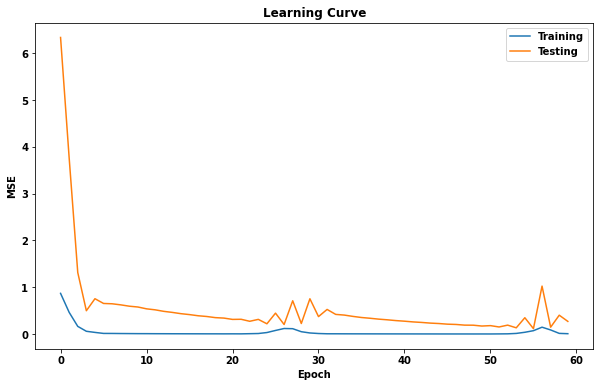

Epoch : 0 , training loss : 0.8685571360588074 , validation loss : 6.33502917819553
Epoch : 1 , training loss : 0.4626403042674065 , validation loss : 3.7618110444810657
Epoch : 2 , training loss : 0.16307831961661579 , validation loss : 1.3134577804141574
Epoch : 3 , training loss : 0.05833573764190078 , validation loss : 0.49761637714174056
Epoch : 4 , training loss : 0.034363314509391785 , validation loss : 0.7541095614433289
Epoch : 5 , training loss : 0.012558726435527206 , validation loss : 0.652678734726376
Epoch : 6 , training loss : 0.0120319158770144 , validation loss : 0.6456832786401113
Epoch : 7 , training loss : 0.010255965634714813 , validation loss : 0.6228007343080308
Epoch : 8 , training loss : 0.00909775223582983 , validation loss : 0.5941798388957977
Epoch : 9 , training loss : 0.007924206615425646 , validation loss : 0.5767356687121921
Epoch : 10 , training loss : 0.007464418467134237 , validation loss : 0.5378080275323656
Epoch : 11 , training loss : 0.00659217267

In [18]:
data_module.learning_curve(num_epochs,train_loss,val_loss)

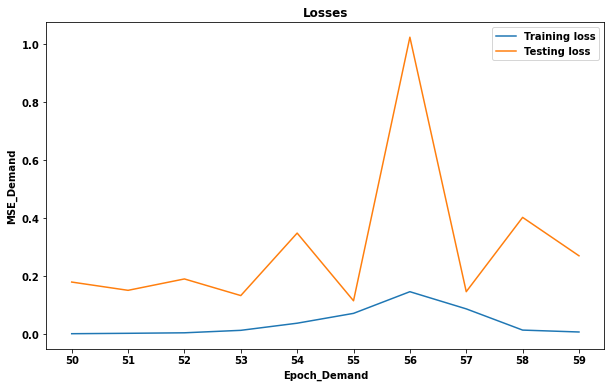

In [19]:
data_module.zoom_learning_curve(start_epoch = 50,
                                end_epoch =60 ,
                                training_loss = train_loss,
                                validation_loss = val_loss)

# Step 5 : Evaluation
This section is to inference the model by feeding in testing data and determine the output forecast value and calculate the RMSE .

It consist of 4 section :

Section 1 : Feed in the train and test data to the model <br>
Section 2 : Reshape both to the original data dimension <br> 
Section 3 : Invert the scaling back to orignal data value <br>
Section 4 : Calculate the RMSE of train and test data

In [20]:
# Section 1 : make predictions
with torch.no_grad():
    y_train_prediction = model(trainX)
    y_test_prediction = model(testX)

# Section 2 : Reshape to original data
y_train_prediction= torch.reshape(y_train_prediction,(y_train_prediction.shape[0],y_train_prediction.shape[1]))
trainY = torch.reshape(trainY,(trainY.shape[0],trainY.shape[1]))
y_test_prediction = torch.reshape(y_test_prediction,(y_test_prediction.shape[0],y_test_prediction.shape[1]))
testY = torch.reshape(testY,(testY.shape[0],testY.shape[1]))

In [21]:
# Section 3 : Invert predictions
y_train_prediction= scaler.inverse_transform(y_train_prediction.numpy())
y_train = scaler.inverse_transform(trainY.numpy())
y_test_prediction = scaler.inverse_transform(y_test_prediction.numpy())
y_test = scaler.inverse_transform(testY.numpy())

In [22]:
# Section 4 : Calculate root mean squared error for both train and test data 
trainScore = math.sqrt(mean_squared_error(y_train, y_train_prediction))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, y_test_prediction))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 5.15 RMSE
Test Score: 41.94 RMSE


# Step 6 : Forecast Plot

>**How to plot multi-step forecast ?**<br>
>**Pipeline** : <br>
    1. First , we store the test data and forecast data in the form of `DataFrame` <br>
    2. Then , we slice the time index from the test time index base on the `window_size shampoo` to create new time index only for the data after the sliding window (data sequencing) <br>
    3. Create a for loop to plot the data sequence by sequence<br>

>**Optional function :**<br>
    1. Turn the `original_plot = True` to observe how sliding window (data sequence) take place in the test data<br>
    2. Assign `details = plot_details`  if you want to add details as such x-axis label , y-axis label,title<br>

In [23]:
plot_details ={"x-axis" : "Day",
          "y-axis" : "Values",
          "title"  : "Synthetic Data"
         }

In [24]:
from matplotlib.lines import Line2D
def multi_step_plot(original_test_data,
                    after_sequence_test_data ,
                    forecast_data,test_time,window_size,
                    n_step ,
                    details = {},
                    original_plot = False):
    
    # Plot Setting
    plt.figure(figsize=(10,6))
    plt.xticks(rotation=45)    
    
    # Store test and forecast data into DataFrame type 
    column_names = ["timestep_" + str(i) for i in range(after_sequence_test_data.shape[1])]
    y_test_dataframe = pd.DataFrame(after_sequence_test_data,columns = column_names)
    y_test_pred_dataframe =pd.DataFrame(forecast_data,columns = column_names)
    
    # Create time index for data after sequence
    time_index_after_sequence = test_time[window_size:]
    
    # Test Data plot before sliding window(data sequencing)
    if original_plot:
        plt.plot(test_time,original_test_data,marker='x',color="blue")

    # For loop to plot the data step by step base on time index    
    start_idx = 0 
    for row in range(len(y_test_dataframe)):
        
        # Iterate the time index after sequence
        time_index = time_index_after_sequence[start_idx:start_idx+n_step]
        
        # Plot the test data
        plt.plot(time_index,y_test_dataframe.iloc[row],color="green",marker='o')
        
        # Plot the forecast data
        plt.plot(time_index,y_test_pred_dataframe.iloc[row],color="red",marker='o')
        
        # Pointer for time_index_after_sequence
        start_idx += 1
        
    # Customize the legend
    custom_lines = [Line2D([0], [0], color="green", lw=4),
                Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="blue", lw=4)]
    plt.legend(custom_lines, ['Test Data After Sequencing', 'Forecast Data', 'Test Data Before Sequencing'])
    
    # Extra details - Optional function
    if details != {}:
        plt.xlabel(details["x-axis"])
        plt.ylabel(details["y-axis"])
        plt.title(details["title"])
    

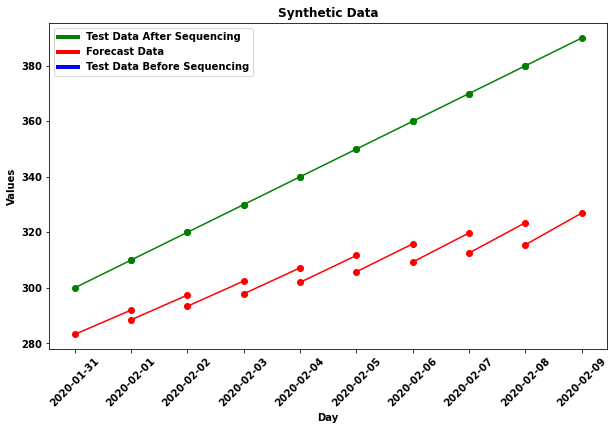

In [25]:
# Use the multi_step_plot function
multi_step_plot(original_test_data = test_data,
                after_sequence_test_data = y_test ,
                forecast_data = y_test_prediction,
                test_time = test_time,
                window_size = window_size ,
                n_step = n_step,
                details = plot_details,
                original_plot = False)

***

# Part 2 : Exercise for Univariate (Solution)
## Task : Using LSTM to create a model that can predict lastest sales of shampoo

## Hyperparameter
>**Instruction** : <br>
You are require to fill the `None` with suitable value to make the model converge

>**Expected Result** : <br>
Train Score <= 60 RMSE<br>
Test Score <= 120 RMSE<br>

In [54]:
#Hyperparameter
num_epochs_shampoo = 100
split_ratio = 0.70
n_step_shampoo = 2
batch_size_shampoo = 2
window_size_shampoo = 2

#Hidden Layer for LSTM
hidden_dim_shampoo = 32



# Step 1 : Data Preparation
>**Instruction** : <br>
Read the file using `pd.read_csv`<br>
Your file path `../../datasets/others/shampoo-sales.csv`

>**Expected Result** : <br>
Example of first 5 data :

month| sales
---|---
0| 1-01|    266.0
1| 1-02|    145.9
2| 1-03|    183.1
3| 1-04|    119.3
4| 1-05|    180.3

In [55]:
# Read CSV file 

### BEGIN SOLUTION
shampoo = pd.read_csv('../../datasets/others/shampoo-sales.csv')
### END SOLUTION

shampoo.head() 

,month,sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


>**Instruction** : <br>
Set the dataframe index as 'month' using `df.set_index`

>**Expected Result** : <br>
Example of first 5 data

month| month| sales
---|---|---
1-01| 1-01|    266.0
1-02| 1-02|    145.9
1-03| 1-03|    183.1
1-04| 1-04|    119.3
1-05| 1-05|    180.3

In [56]:
### BEGIN SOLUTION
shampoo_ts =  shampoo.set_index(shampoo['month'])  
### END SOLUTION

shampoo_ts.head() 

,month,sales
month,,
1-01,1-01,266.0
1-02,1-02,145.9
1-03,1-03,183.1
1-04,1-04,119.3
1-05,1-05,180.3


>**Instruction** : <br>
Save the data in Series form using `pd.Series`

>**Expected Result** : <br>
Example of first 5 data

month|---
---|---
1-01|    266.0
1-02|    145.9
1-03|    183.1
1-04|    119.3
1-05|    180.3

In [57]:
### START SOLUTION
shampoo_ts = pd.Series(shampoo_ts['sales'])
### END SOLUTION
shampoo_ts.head()

month
1-01    266.0
1-02    145.9
1-03    183.1
1-04    119.3
1-05    180.3
Name: sales, dtype: float64

Text(0.5, 1.0, 'Time Series plot ')

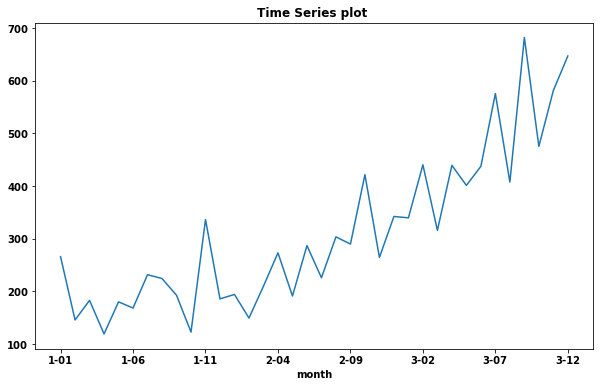

In [58]:
plt.figure(figsize=(10,6))
shampoo_ts.plot()
plt.title("Time Series plot ")

### Data Splitting

In [59]:
#split data by indexing 
split_data = round(len(shampoo_ts)*split_ratio)
split_data

25

In [60]:
# Visualize data shape after splitting
train_data_shampoo = shampoo_ts[:split_data]
test_data_shampoo = shampoo_ts[split_data:]
train_time_shampoo = shampoo_ts.index[:split_data]
test_time_shampoo = shampoo_ts.index[split_data:]
print("train_data_shampoo_shape")
print(train_data_shampoo.shape)
print("test_data_shampoo_shape")
print(test_data_shampoo.shape)

train_data_shampoo_shape
(25,)
test_data_shampoo_shape
(11,)


### Data Normalization
>**Instruction** : <br>
Use `MinMaxScaler()` to normalize the data, save your data scaler into `scaler_shampoo` and your train and test scaled data into `train_shampoo_scaled` and `test_shampoo_scaled`.<br>

Example :<br>
`train_shampoo_scaled = scaler_shampoo.transform(train_data_shampoo.values.reshape(-1,1))`

In [61]:
scaler_shampoo = MinMaxScaler().fit(train_data_shampoo.values.reshape(-1,1))
train_shampoo_scaled = scaler_shampoo.transform(train_data_shampoo.values.reshape(-1,1))
test_shampoo_scaled = scaler_shampoo.transform(test_data_shampoo.values.reshape(-1,1))

## Data Sequencing 
>**Instruction** : <br>
Use `univariate_multi_step` from the `data_module`, take the scaled data save your data in to respective `x` and `y` variable.<br>

Example :<br>
`trainX_shampoo ,trainY_shampoo =  data_module.univariate_multi_step(train_shampoo_scaled,window_size_shampoo,n_step_shampoo)`

In [62]:
trainX_shampoo ,trainY_shampoo =  data_module.univariate_multi_step(train_shampoo_scaled,window_size_shampoo,n_step_shampoo)
testX_shampoo , testY_shampoo = data_module.univariate_multi_step(test_shampoo_scaled,window_size_shampoo,n_step_shampoo)
print(f"trainX shape:{trainX_shampoo.shape} trainY shape:{trainY_shampoo.shape}\n")
print(f"testX shape:{testX_shampoo.shape} testY shape:{testY_shampoo.shape}")

trainX shape:(22, 2, 1) trainY shape:(22, 2, 1)

testX shape:(8, 2, 1) testY shape:(8, 2, 1)


## Data Transform
>**Instruction** : <br>
Transform the data from `ndarray` to `torch tensor`<br>

Example :<br>
`trainX_shampoo = torch.from_numpy(trainX_shampoo).type(torch.Tensor)`<br>
`trainY_shampoo = torch.from_numpy(trainY_shampoo).type(torch.Tensor)`<br>

In [63]:
#Transfrom numpy to Pytorch tensor
trainX_shampoo = torch.as_tensor(trainX_shampoo).float()
trainY_shampoo = torch.as_tensor(trainY_shampoo).float()
testX_shampoo = torch.as_tensor(testX_shampoo).float()
testY_shampoo = torch.as_tensor(testY_shampoo).float()
print(f"trainX shape:{trainX_shampoo.shape} trainY shape:{trainY_shampoo.shape}\n")
print(f"testX shape:{testX_shampoo.shape} testX shape:{testY_shampoo.shape}")


trainX shape:torch.Size([22, 2, 1]) trainY shape:torch.Size([22, 2, 1])

testX shape:torch.Size([8, 2, 1]) testX shape:torch.Size([8, 2, 1])


## Data Iterator
>**Instruction** : <br>
You are require to create data interator to able the data store in batches<br>

Example :<br>
`train_dataset_shampoo = TensorDataset(trainX_shampoo, trainY_shampoo)`<br>
`train_iter_shampoo = DataLoader(train_dataset_shampoo,batch_size=batch_size_shampoo,shuffle=False)`

In [64]:
# Create Iterator
train_dataset_shampoo = TensorDataset(trainX_shampoo, trainY_shampoo)
train_iter_shampoo = DataLoader(train_dataset_shampoo,batch_size=batch_size_shampoo,shuffle=False)

test_dataset_shampoo = TensorDataset(testX_shampoo, testY_shampoo)
test_iter_shampoo = DataLoader(test_dataset_shampoo,batch_size=batch_size_shampoo,shuffle=False)

## Input Model
>**Instruction** : <br>
You are require to input the correct model from `LSTM_module`.You are feel free to use any type of LSTM configuration.Please input the correct attributes and have a fun with it and save your model with the name `model_shampoo` <br>

In [65]:
#Arguments for LSTM model
### BEGIN SOLUTION
n_feature = 1 
#1 for vanila LSTM , >1 is mean stacked LSTM
num_layers_shampoo = 1

#Vanila , Stacked LSTM
model_shampoo = LSTM_module.LSTM(n_feature = n_feature ,
                         hidden_dim = hidden_dim_shampoo,
                         num_layers = num_layers_shampoo,
                         n_step = n_step_shampoo)

# Bidirectional LSTM
# model_shampoo = LSTM_module.BidirectionalLSTM(n_feature = n_feature ,
#                          hidden_dim = hidden_dim_shampoo,
#                          num_layers = num_layers_shampoo,
#                          n_step = n_step_shampoo)
### END SOLUTION

>**Instruction** : <br>
Use `MSELoss` as the loss function and `Adam` as the optimizer.Your are require to save `MSELoss` into to variable name `loss_fn_shampoo` and `Adam` optimizer into `optimiser_shampoo`<br>

In [66]:
loss_fn_shampoo = torch.nn.MSELoss()

optimiser_shampoo = torch.optim.Adam(model_shampoo.parameters(), lr=0.01)

## Step 3 : Training
>**Instruction** : <br>
Input your training function from `LSTM_module`<br>

In [75]:
# Start Training 
### BEGIN SOLUTION
train_loss_shampoo,val_loss_shampoo = LSTM_module.training(num_epochs_shampoo,train_iter_shampoo,test_iter_shampoo,optimiser_shampoo,loss_fn_shampoo,model_shampoo)
### END SOLUTION

## Step 4 : Validate Model

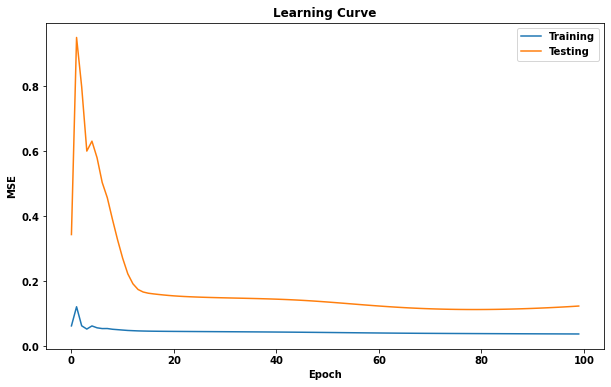

Epoch : 0 , training loss : 0.06233304061672904 , validation loss : 0.3433772660791874
Epoch : 1 , training loss : 0.12119243717329069 , validation loss : 0.9499602094292641
Epoch : 2 , training loss : 0.0625513784418052 , validation loss : 0.7977941706776619
Epoch : 3 , training loss : 0.052552273708649656 , validation loss : 0.6002853512763977
Epoch : 4 , training loss : 0.062171750447966835 , validation loss : 0.630828820168972
Epoch : 5 , training loss : 0.056392590261318466 , validation loss : 0.5797114595770836
Epoch : 6 , training loss : 0.05403260725804351 , validation loss : 0.5038881748914719
Epoch : 7 , training loss : 0.054175659717822615 , validation loss : 0.456723116338253
Epoch : 8 , training loss : 0.0519407222640108 , validation loss : 0.3904261291027069
Epoch : 9 , training loss : 0.050714796324345196 , validation loss : 0.32748950086534023
Epoch : 10 , training loss : 0.04945325597443364 , validation loss : 0.27041337080299854
Epoch : 11 , training loss : 0.04825303

In [68]:
# Plot Learning Curve 
data_module.learning_curve(num_epochs_shampoo,train_loss = train_loss_shampoo,
                           val_loss = val_loss_shampoo)

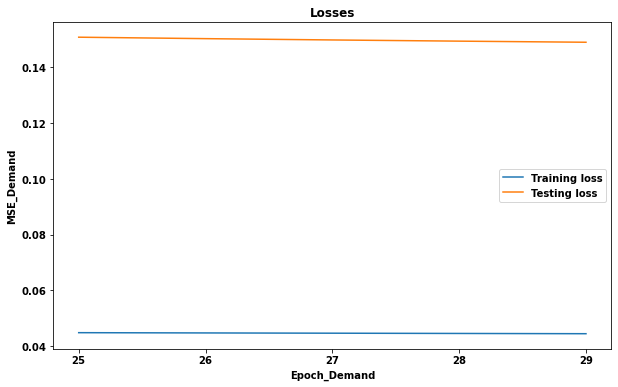

In [69]:
# Zoom in to visualize the graph by fill in start_epoch and end_epoch that want to analyse
data_module.zoom_learning_curve(start_epoch = 25,
                                end_epoch = 30,
                                training_loss = train_loss_shampoo,
                                validation_loss = val_loss_shampoo)

## Step 6 : Forecast Plot

In [70]:
# Make predictions
with torch.no_grad():
    y_train_prediction_shampoo= model_shampoo(trainX_shampoo)
    y_test_prediction_shampoo= model_shampoo(testX_shampoo)

# Reshape to original data
y_train_prediction_shampoo = torch.reshape(y_train_prediction_shampoo,(y_train_prediction_shampoo.shape[0],y_train_prediction_shampoo.shape[1]))
trainY_shampoo = torch.reshape(trainY_shampoo,(trainY_shampoo.shape[0],trainY_shampoo.shape[1]))
y_test_prediction_shampoo = torch.reshape(y_test_prediction_shampoo,(y_test_prediction_shampoo.shape[0],y_test_prediction_shampoo.shape[1]))
testY_shampoo = torch.reshape(testY_shampoo,(testY_shampoo.shape[0],testY_shampoo.shape[1]))

In [71]:
# Invert predictions
y_train_pred_shampoo = scaler_shampoo.inverse_transform(y_train_prediction_shampoo)
y_train_shampoo = scaler_shampoo.inverse_transform(trainY_shampoo)
y_test_pred_shampoo = scaler_shampoo.inverse_transform(y_test_prediction_shampoo)
y_test_shampoo = scaler_shampoo.inverse_transform(testY_shampoo)

In [72]:
print("y-test\t\ty-predict")
for i in range(len(y_test_shampoo)):
    print(f"{y_test_shampoo[i]}\t\t{y_test_pred_shampoo[i]}")

y-test		y-predict
[439.29998939 401.29999741]		[393.23077967 401.05265768]
[401.29999741 437.40001231]		[346.09691177 394.85518205]
[437.40001231 575.50001708]		[425.88775055 456.88159734]
[575.50001708 407.59999821]		[409.3806749  445.68137969]
[407.59999821 681.99999722]		[441.31798754 452.84531275]
[681.99999722 475.29998369]		[494.25705065 517.1520573 ]
[475.29998369 581.29998693]		[424.34471965 418.64893267]
[581.29998693 646.89999017]		[543.50163981 551.76289855]


In [73]:
# Calculate root mean squared error
trainScore_shampoo = math.sqrt(mean_squared_error(y_train_shampoo, y_train_pred_shampoo))
print('Train Score: %.2f RMSE' % (trainScore_shampoo))
testScore_shampoo = math.sqrt(mean_squared_error(y_test_shampoo, y_test_pred_shampoo))
print('Test Score: %.2f RMSE' % (testScore_shampoo))

Train Score: 56.62 RMSE
Test Score: 106.19 RMSE


<!-- multi_step_plot(original_test_data = test_data,
                after_sequence_test_data = y_test ,
                forecast_data = y_test_prediction,
                test_time = test_time,
                window_size = window_size ,
                n_step = n_step,
                details = plot_details,
                original_plot = False) -->

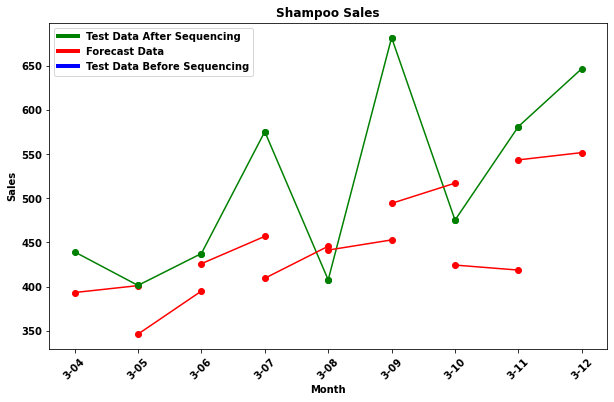

In [74]:
shampoo_details ={"x-axis" : "Month",
          "y-axis" : "Sales",
          "title"  : "Shampoo Sales"
         }
multi_step_plot(original_test_data = test_data_shampoo,
                after_sequence_test_data = y_test_shampoo ,
                forecast_data = y_test_pred_shampoo,
                test_time = test_time_shampoo,
                window_size = window_size_shampoo ,
                n_step = n_step_shampoo,
                details = shampoo_details,
                original_plot = False)

## Reference
1. [Multistep Time Series Forecasting with LSTMs in Python](https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/)
2. [Deep Learning for Time Series Forecasting (Predict the Future with MLPs,CNNs and LSTMs in Python) , Jason Brownlee](https://machinelearningmastery.com/deep-learning-for-time-series-forecasting/)